```{contents}
```
## **Planner Agent in LangGraph**

A **Planner Agent** in LangGraph is a specialized decision-making component responsible for **task decomposition, strategy formation, and execution planning** within complex LLM-driven systems.
It enables **long-horizon reasoning**, coordination among agents, and adaptive control of multi-step workflows.

---

### **1. Motivation & Intuition**

Single-pass LLM calls are insufficient for complex problems.
Real-world tasks require:

* **Decomposition** — breaking goals into subtasks
* **Sequencing** — ordering operations correctly
* **Adaptation** — revising plans as new information appears
* **Coordination** — orchestrating multiple agents and tools

The Planner Agent serves as the **cognitive control layer** of a LangGraph system.

---

### **2. Conceptual Architecture**

```
User Goal
   ↓
Planner Agent
   ↓
Execution Graph
   ├── Agent A (Research)
   ├── Agent B (Computation)
   ├── Agent C (Verification)
   ↓
Final Output
```

The planner operates on the **shared graph state**, continuously shaping execution.

---

### **3. Planner Responsibilities**

| Function              | Description                        |
| --------------------- | ---------------------------------- |
| Goal Analysis         | Understand intent and constraints  |
| Task Decomposition    | Split into ordered subtasks        |
| Dependency Resolution | Determine execution order          |
| Resource Allocation   | Choose agents/tools                |
| Plan Representation   | Store plan in state                |
| Monitoring            | Observe progress                   |
| Replanning            | Modify plan on failure or feedback |

---

### **4. Planner State Design**

```python
class State(TypedDict):
    goal: str
    plan: list[str]
    current_step: int
    results: dict
    done: bool
```

The **plan** becomes part of the global state and drives the graph.

---

### **5. Basic Planner Workflow**

```
Goal → Plan → Execute Step → Observe → Replan? → Next Step → … → Done
```

This naturally forms a **cyclic graph**.

---

### **6. Minimal Working Example**

```python
from langgraph.graph import StateGraph, END
from typing import TypedDict, List

class State(TypedDict):
    goal: str
    plan: List[str]
    step: int
    done: bool

def planner(state):
    return {
        "plan": ["research", "compute", "verify"],
        "step": 0,
        "done": False
    }

def executor(state):
    current = state["plan"][state["step"]]
    print("Executing:", current)
    state["step"] += 1
    if state["step"] >= len(state["plan"]):
        state["done"] = True
    return state

def router(state):
    return END if state["done"] else "executor"

builder = StateGraph(State)

builder.add_node("planner", planner)
builder.add_node("executor", executor)

builder.set_entry_point("planner")
builder.add_edge("planner", "executor")
builder.add_conditional_edges("executor", router, {
    "executor": "executor",
    END: END
})

graph = builder.compile()
graph.invoke({"goal": "analyze market"})
```

---

### **7. Planner Variants**

| Variant                  | Use Case                    |
| ------------------------ | --------------------------- |
| Static Planner           | Predefined workflow         |
| Dynamic Planner          | LLM-generated plans         |
| Hierarchical Planner     | Multi-level planning        |
| Multi-Agent Planner      | Coordinates multiple agents |
| Reflexive Planner        | Self-evaluates and replans  |
| Constraint-Based Planner | Honors strict rules         |

---

### **8. Production Enhancements**

| Feature          | Purpose                 |
| ---------------- | ----------------------- |
| Checkpointing    | Resume planning         |
| Plan Validation  | Prevent invalid actions |
| Cost Estimation  | Budget control          |
| Human Approval   | Safety gate             |
| Replanning Logic | Error recovery          |
| Metrics          | Planning efficiency     |

---

### **9. Why Planner Agents Matter**

| Without Planner     | With Planner             |
| ------------------- | ------------------------ |
| Rigid pipelines     | Adaptive workflows       |
| Single-step         | Long-horizon reasoning   |
| Fragile             | Robust systems           |
| Manual coordination | Autonomous orchestration |

---

### **10. Mental Model**

The Planner Agent functions as the **executive cortex** of an AI system:

> **Decide → Direct → Monitor → Correct**

This makes LangGraph suitable for building **enterprise-grade autonomous systems**.


### Demonstration

In [1]:
# ============================
# Planner Agent — Single-Cell Demonstration in LangGraph
# ============================

from typing import TypedDict, List
from langgraph.graph import StateGraph, END

# ----------------------------
# 1. Define Shared State
# ----------------------------
class State(TypedDict):
    goal: str
    plan: List[str]
    step: int
    done: bool
    results: dict

# ----------------------------
# 2. Planner Agent
# ----------------------------
def planner(state: State) -> State:
    print("\n[Planner] Generating plan...")
    plan = ["research", "analyze", "verify", "summarize"]
    return {
        "plan": plan,
        "step": 0,
        "done": False,
        "results": {}
    }

# ----------------------------
# 3. Executor Agent
# ----------------------------
def executor(state: State) -> State:
    task = state["plan"][state["step"]]
    print(f"[Executor] Executing: {task}")

    # simulate task output
    state["results"][task] = f"{task} complete"
    state["step"] += 1

    if state["step"] >= len(state["plan"]):
        state["done"] = True

    return state

# ----------------------------
# 4. Router (Loop Controller)
# ----------------------------
def router(state: State):
    return END if state["done"] else "executor"

# ----------------------------
# 5. Build Graph
# ----------------------------
builder = StateGraph(State)

builder.add_node("planner", planner)
builder.add_node("executor", executor)

builder.set_entry_point("planner")
builder.add_edge("planner", "executor")

builder.add_conditional_edges("executor", router, {
    "executor": "executor",
    END: END
})

graph = builder.compile()

# ----------------------------
# 6. Run System
# ----------------------------
result = graph.invoke({"goal": "launch product"})

print("\nFinal State:")
print(result)



[Planner] Generating plan...
[Executor] Executing: research
[Executor] Executing: analyze
[Executor] Executing: verify
[Executor] Executing: summarize

Final State:
{'goal': 'launch product', 'plan': ['research', 'analyze', 'verify', 'summarize'], 'step': 4, 'done': True, 'results': {'research': 'research complete', 'analyze': 'analyze complete', 'verify': 'verify complete', 'summarize': 'summarize complete'}}


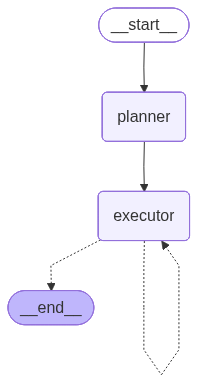

In [2]:
from IPython.display import Image
Image(graph.get_graph().draw_mermaid_png())